# High-dimensional Analyzers

@[Chaoming Wang](https://github.com/chaoming0625)

It's hard to analyze high-dimensional systems. However, we have to analyze high-dimensional systems.

Here, based on numerical optimization methods, BrainPy provides [brainpy.analysis.SlowPointFinder](../apis/auto/analysis/generated/brainpy.analysis.highdim.SlowPointFinder.rst) to help users find **slow points** (or **fixed points**) [1] for your high-dimensional dynamical systems.

In [5]:
import brainpy as bp
import brainpy.math as bm

bp.math.set_platform('cpu')

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

## What are slow points?

For the given system,

$$
\dot{x} = f(x),
$$

we wish to find values $x^∗$ around which the system is approximately linear. Using Taylor series expansion, we have

$$
f(x^* + \delta x) = f(x^*) + f'(x^*)\delta x + 1/2 \delta x f''(x^*) \delta x + \cdots
$$

We want the first derivative term (i.e., the linear term) dominates, which means $f(x^*) = 0$ or $f(x^*) \approx 0$. 

- For $f(x^*) \approx 0$ which is nonzero but small, we call the point $x^*$ is a **slow point**. 
- More specially, for $f(x^*) = 0$, this point $x^*$ is a **fixed point**. 

## How to find slow points?

In order to find slow points, we can first define an auxiliary scalar function for your continous system $\dot{x} = f(x)$, 

$$
p(x) = |f(x)|^2.
$$

Or, if your system is discrete $x_n = f(x_{n-1})$, the auxiliary scalar function can be defined as

$$
p(x) = |x - f(x)|^2.
$$

If $x^*$ is a slow point, $p(x^*) \to 0$. 

Then, by minimizing the scalar function $p(x)$, we can get the candidate points for slow points and for further linearization. For the linear system, it's stability is evaluated by the eigenvalues of Jacobian matrix. 

Here, BrainPy provides [brainpy.analysis.SlowPointFinder](../apis/auto/analysis/generated/brainpy.analysis.highdim.SlowPointFinder.rst). It receives a function which ``f_cell`` defines $f(x)$, and ``f_type`` which specify the type of the function (it can be "continuous" or "discrete"). Then, ``brainpy.analysis.SlowPointFinder`` can help you:

- optimize to find the fixed/slow points with gradient descent algorithms (``find_fps_with_gd_method()``) or nonlinear optimization solver (``find_fps_with_opt_solver()``)
- exclude any fixed points whose losses are above threshold: ``filter_loss()``
- exclude any non-unique fixed points according to a tolerance: ``keep_unique()``
- exclude any far-away "outlier" fixed points: ``exclude_outliers()``
- computing the jacobian matrix for the given fixed/slow points: ``compute_jacobians()``

## Example 1: Decision Making Model

``brainpy.analysis.SlowPointFinder`` is aimed to find slow/fixed points of high-dimensional systems. Of course, it can optimize to find fixed points of low-dimensional systems. We take the 2D decision making system as an example. 

In [2]:
# parameters

gamma = 0.641  # Saturation factor for gating variable
tau = 0.06  # Synaptic time constant [sec]
a = 270.
b = 108.
d = 0.154

JE = 0.3725  # self-coupling strength [nA]
JI = -0.1137  # cross-coupling strength [nA]
JAext = 0.00117  # Stimulus input strength [nA]

mu = 20.  # Stimulus firing rate [spikes/sec]
coh = 0.5  # Stimulus coherence [%]
Ib1 = 0.3297
Ib2 = 0.3297

In [3]:
@bp.odeint
def int_s1(s1, t, s2, coh=0.5, mu=20.):
  I1 = JE * s1 + JI * s2 + Ib1 + JAext * mu * (1. + coh)
  r1 = (a * I1 - b) / (1. - bm.exp(-d * (a * I1 - b)))
  return - s1 / tau + (1. - s1) * gamma * r1

@bp.odeint
def int_s2(s2, t, s1, coh=0.5, mu=20.):
  I2 = JE * s2 + JI * s1 + Ib2 + JAext * mu * (1. - coh)
  r2 = (a * I2 - b) / (1. - bm.exp(-d * (a * I2 - b)))
  return - s2 / tau + (1. - s2) * gamma * r2

def step(s):
    ds1 = int_s1.f(s[0], 0., s[1])
    ds2 = int_s2.f(s[1], 0., s[0])
    return bm.asarray([ds1.value, ds2.value])

We first use [brainpy.analysis.PhasePlane2D](./lowdim_analysis.ipynb) to get the standard answer. 

In [6]:
analyzer = bp.analysis.PhasePlane2D(
    model=[int_s1, int_s2],
    target_vars={'s1': [0, 1], 's2': [0, 1]},
    resolutions=0.001,
)
analyzer.plot_fixed_point(select_candidates='aux_rank', with_plot=False)

I am searching fixed points ...
I am filtering out fixed point candidates with auxiliary function ...
I am trying to find fixed points by optimization ...
	There are 100 candidates
I am trying to filter out duplicate fixed points ...
	Found 3 fixed points.
	#1 s1=0.28276315331459045, s2=0.40635165572166443 is a saddle node.
	#2 s1=0.013946513645350933, s2=0.6573889851570129 is a stable node.
	#3 s1=0.7004519104957581, s2=0.004864314571022987 is a stable node.


Then, let's check whether the high-dimensional analyzer also works. 

In [9]:
finder = bp.analysis.SlowPointFinder(f_cell=step)
finder.find_fps_with_gd_method(
    candidates=bm.random.random((1000, 2)), tolerance=1e-5, num_batch=200,
    opt_setting=dict(method=bm.optimizers.Adam,
                     lr=bm.optimizers.ExponentialDecay(0.01, 1, 0.9999)),
)
finder.filter_loss(1e-5)
finder.keep_unique()

Optimizing with Adam to find fixed points:
    Batches 1-200 in 0.52 sec, Training loss 0.0576312058
    Batches 201-400 in 0.52 sec, Training loss 0.0049517932
    Batches 401-600 in 0.53 sec, Training loss 0.0007580096
    Batches 601-800 in 0.52 sec, Training loss 0.0001687836
    Batches 801-1000 in 0.51 sec, Training loss 0.0000421500
    Batches 1001-1200 in 0.52 sec, Training loss 0.0000108371
    Batches 1201-1400 in 0.52 sec, Training loss 0.0000027990
    Stop optimization as mean training loss 0.0000027990 is below tolerance 0.0000100000.
Excluding fixed points with squared speed above tolerance 1e-05:
    Kept 962/1000 fixed points with tolerance under 1e-05.
Excluding non-unique fixed points:
    Kept 3/962 unique fixed points with uniqueness tolerance 0.025.


In [10]:
finder.fixed_points

array([[0.7004518 , 0.00486438],
       [0.28276336, 0.40635186],
       [0.01394662, 0.65738887]], dtype=float32)

Yeah, the fixed points found by ``brainpy.analysis.PhasePlane2D`` and ``brainpy.analysis.SlowPointFinder`` are nearly the same. 

## Example 2: Continuous-attractor Neural Network

Continuous-attractor neural network [2] proposed by Si Wu is a special model which has a line of attractors. 

In [12]:
class CANN1D(bp.NeuGroup):
  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4., z_min=-bm.pi, z_max=bm.pi, name=None):
    super(CANN1D, self).__init__(size=num, name=name)

    # parameters
    self.tau = tau  # The synaptic time constant
    self.k = k  # Degree of the rescaled inhibition
    self.a = a  # Half-width of the range of excitatory connections
    self.A = A  # Magnitude of the external input
    self.J0 = J0  # maximum connection value

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)  # The encoded feature values
    self.rho = num / self.z_range  # The neural density
    self.dx = self.z_range / num  # The stimulus density

    # variables
    self.u = bm.Variable(bm.zeros(num))
    self.input = bm.Variable(bm.zeros(num))

    # The connection matrix
    self.conn_mat = self.make_conn(self.x)

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, u, t, Iext):
    r1 = bm.square(u)
    r2 = 1.0 + self.k * bm.sum(r1)
    r = r1 / r2
    Irec = bm.dot(self.conn_mat, r)
    du = (-u + Irec + Iext) / self.tau
    return du

  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  def make_conn(self, x):
    assert bm.ndim(x) == 1
    x_left = bm.reshape(x, (-1, 1))
    x_right = bm.repeat(x.reshape((1, -1)), len(x), axis=0)
    d = self.dist(x_left - x_right)
    Jxx = self.J0 * bm.exp(-0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a)
    return Jxx

  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, _t, _dt):
    self.u[:] = self.integral(self.u, _t, self.input)
    self.input[:] = 0.

  def cell(self, u):
    return self.derivative(u, 0., 0.)

In [19]:
def visualize_fixed_points(fps, plot_ids=(0,), xs=None):
  for i in plot_ids:
    if xs is None:
      plt.plot(fps[i], label=f'FP-{i}')
    else:
      plt.plot(xs, fps[i], label=f'FP-{i}')
  plt.legend()
  plt.show()

In [13]:
cann = CANN1D(num=512, k=0.1, A=30)

These attractors is a series of bumps. Therefore we can initialize our candidate points with noisy bumps. 

In [14]:
candidates = cann.get_stimulus_by_pos(bm.arange(-bm.pi, bm.pi, 0.01).reshape((-1, 1)))
candidates += bm.random.normal(0., 0.01, candidates.shape)

In [16]:
finder = bp.analysis.SlowPointFinder(f_cell=cann.cell)
finder.find_fps_with_opt_solver(candidates)
finder.filter_loss(1e-6)
finder.keep_unique()

Optimizing to find fixed points:
    Found 629 fixed points from 629 initial points.
Excluding fixed points with squared speed above tolerance 1e-06:
    Kept 357/629 fixed points with tolerance under 1e-06.
Excluding non-unique fixed points:
    Kept 357/357 unique fixed points with uniqueness tolerance 0.025.


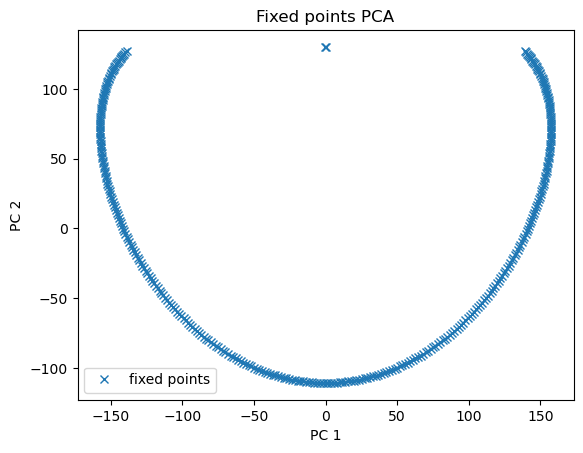

In [17]:
pca = PCA(2)
fp_pcs = pca.fit_transform(finder.fixed_points)
plt.plot(fp_pcs[:, 0], fp_pcs[:, 1], 'x', label='fixed points')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed points PCA')
plt.legend()
plt.show()

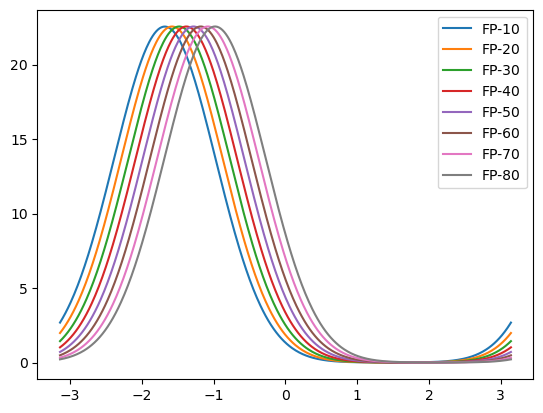

In [23]:
visualize_fixed_points(finder.fixed_points, plot_ids=(10, 20, 30, 40, 50, 60, 70, 80), xs=cann.x)

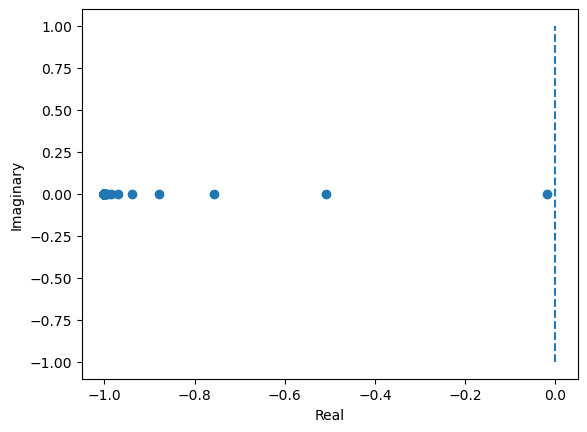

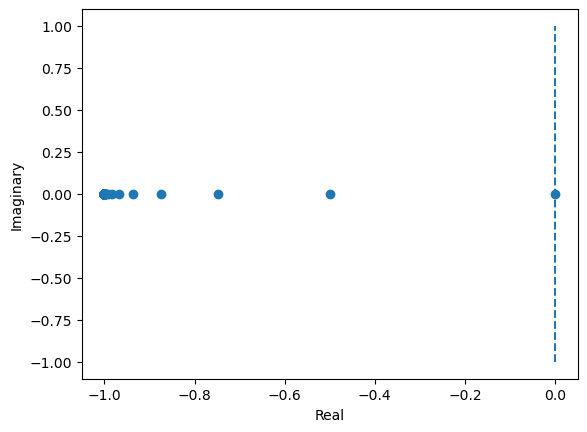

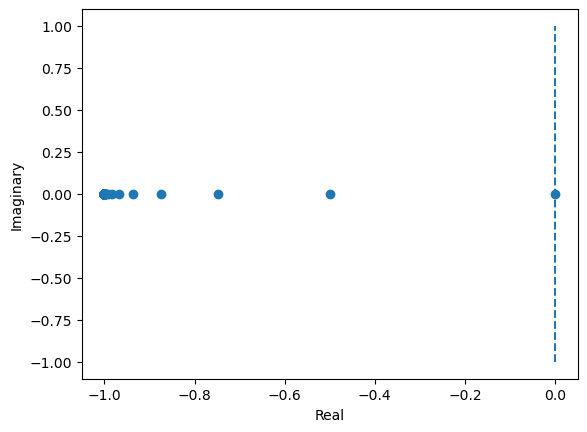

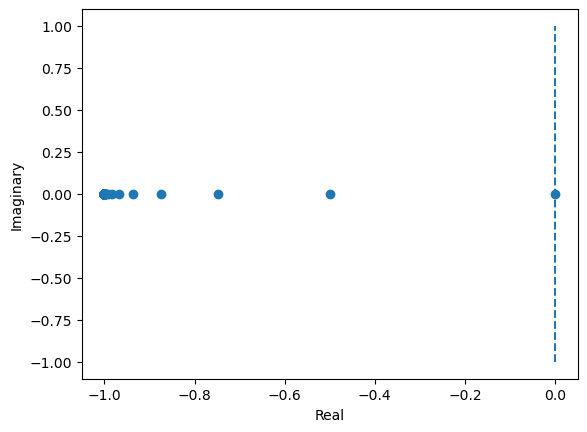

In [25]:
num = 4
J = finder.compute_jacobians(finder.fixed_points[:num])
for i in range(num):
    eigval, eigvec = np.linalg.eig(np.asarray(J[i]))
    plt.figure()
    plt.scatter(np.real(eigval), np.imag(eigval))
    plt.plot([0, 0], [-1, 1], '--')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.show()

More examples of dynamics analysis, for example, analyzing the fixed points in a recurrent neural network, please see [BrainPy Examples](https://brainpy-examples.readthedocs.io/). 

## References

[1] Sussillo, D. , and  O. Barak . "Opening the Black Box: Low-Dimensional Dynamics in High-Dimensional Recurrent Neural Networks." Neural computation 25.3(2013):626-649.

[2] Si Wu, Kosuke Hamaguchi, and Shun-ichi Amari. “Dynamics and computation of continuous attractors.” Neural computation 20.4 (2008): 994-1025.